In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import models
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os
from datetime import datetime

Using TensorFlow backend.


In [2]:
img_src_folder = "lung-segmentation/uniq"
os.listdir(img_src_folder)

['p17',
 'p5',
 'p7',
 'multigif.py',
 'p13',
 'p11',
 'p16',
 'p6',
 'p8',
 'p15',
 'p14',
 'p1',
 'p4',
 'p18',
 'p3',
 'p19',
 'p12',
 'p9',
 'p10',
 'p2',
 'gifs.zip',
 'p20']

In [3]:
#1-5: normal patients, 11-20: covid patients.
normal_patients = []
covid_patients = []
for root, dirs, files in os.walk(img_src_folder):
    for d in dirs:
        if d[0] == 'p':
            num = int(d[1:])
            if num <= 5: normal_patients.append(d)
            elif num >= 11: covid_patients.append(d)


In [4]:
sorted(normal_patients)

['p1', 'p2', 'p3', 'p4', 'p5']

In [5]:
sorted(covid_patients)

['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20']

In [6]:
now = datetime.now()
#defining the minimum number of patients of each class that will be in the test set.
test_patients_per_label = 0
#building the test set with the declared num of patients of each class
TEST_IMG_FOLDERS = sorted(normal_patients)[0:test_patients_per_label]
TEST_IMG_FOLDERS = sorted(covid_patients)[0:test_patients_per_label]

#splitting the test data and the rest (training and validation)
if test_patients_per_label > 0:
    for n in range(test_patients_per_label):
        normal_patients.pop(0)
        covid_patients.pop(0)
        
#defining the number of patients in training set
num_train_patients = int(0.8*min(len(normal_patients), len(covid_patients)))
        
train_normal_folders = sorted(normal_patients)[0:num_train_patients]
train_label_1 = ['normal' for i in range(len(train_normal_folders))]

validation_normal_folders = list(set(normal_patients) - set(train_normal_folders))
validation_label_1 = ['normal' for i in range(len(validation_normal_folders))]

train_covid_folders = sorted(covid_patients)[0:num_train_patients]
train_label_2 = ['covid' for i in range(len(train_covid_folders))]

validation_covid_folders = list(set(covid_patients) - set(train_covid_folders))
validation_label_2 = ['covid' for i in range(len(validation_covid_folders))]

#balancing validation set members for each label (normal or covid)
label_1_size = len(validation_normal_folders)
label_2_size = len(validation_covid_folders)
dif = label_1_size - label_2_size
if dif != 0:
    greater_label = validation_normal_folders #supposing one label as having more elements
    if label_2_size > label_1_size:
        greater_label = validation_covid_folders
        dif = abs(dif)
    for n in range(dif): #deletes an random majoritary's label patient until labels are balanced
        index = random.randint(0, len(greater_label) - 1)
        TEST_IMG_FOLDERS.append(greater_label[index])
        greater_label.pop(index)

TRAIN_IMG_SRC_FOLDER = img_src_folder
VALIDATION_IMG_SRC_FOLDER = img_src_folder
TEST_IMG_SRC_FOLDER = img_src_folder

TRAIN_IMG_FOLDERS = dict(zip(train_normal_folders, train_label_1))
TRAIN_IMG_FOLDERS.update(dict(zip(train_covid_folders, train_label_2)))

VALIDATION_IMG_FOLDERS = dict(zip(validation_normal_folders, validation_label_1))
VALIDATION_IMG_FOLDERS.update(dict(zip(validation_covid_folders, validation_label_2)))

In [7]:
TRAIN_IMG_FOLDERS

{'p1': 'normal',
 'p2': 'normal',
 'p3': 'normal',
 'p4': 'normal',
 'p11': 'covid',
 'p12': 'covid',
 'p13': 'covid',
 'p14': 'covid'}

In [8]:
VALIDATION_IMG_FOLDERS

{'p5': 'normal', 'p15': 'covid'}

In [9]:
TEST_IMG_FOLDERS

['p19', 'p20', 'p16', 'p18', 'p17']

In [10]:
CLASSES = len(set([label for label in TRAIN_IMG_FOLDERS.values()]))
EXAM_SLICE = 200
EPOCHS = 10
width = 150
height = 150
print(CLASSES)

2


In [11]:
dfs = []
train_images = {"id": [], "label": []}
validation_images = {"id": [], "label": []}

df_config = [
    (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS, train_images),
    (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS, validation_images)
]

def get_file_path(folder, search_filter=''):
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

for (base, folder, dic) in df_config:
    for img_folder, img_label in folder.items():
        search_folder = "{}/{}".format(base, img_folder)
        imgs_filename = sorted(get_file_path(search_folder, search_filter = 'segmented'))
        imgs_filename = imgs_filename[(len(imgs_filename)-EXAM_SLICE)//2:(len(imgs_filename)+EXAM_SLICE)//2]
        dic["id"].extend(imgs_filename)
        dic["label"].extend([img_label] * len(imgs_filename))
        
    dfs.append(pd.DataFrame(data=dic))

train_df, validation_df = dfs[0], dfs[1]

train_df.to_csv('train_df.csv', index=False)
validation_df.to_csv('validation_df.csv', index=False)

print("Train fold with {} images".format(len(train_df)))
print(train_df.groupby("label").label.count())
print()
print("Validation fold with {} images".format(len(validation_df)))
print(validation_df.groupby("label").label.count())
print("-" * 30)

Train fold with 1600 images
label
covid     800
normal    800
Name: label, dtype: int64

Validation fold with 400 images
label
covid     200
normal    200
Name: label, dtype: int64
------------------------------


Random Visualization of Training Data Samples

In [12]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(width,height))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "normal":"Normal",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

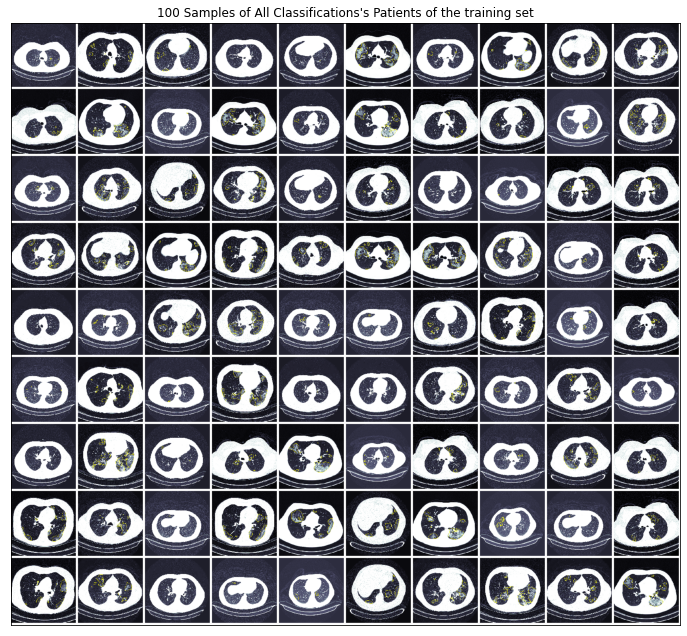

In [13]:
show_gallery("all")

Data Generator

In [14]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1)
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(width, height),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return data_generator

See sample generated images

Found 1 validated image filenames belonging to 1 classes.


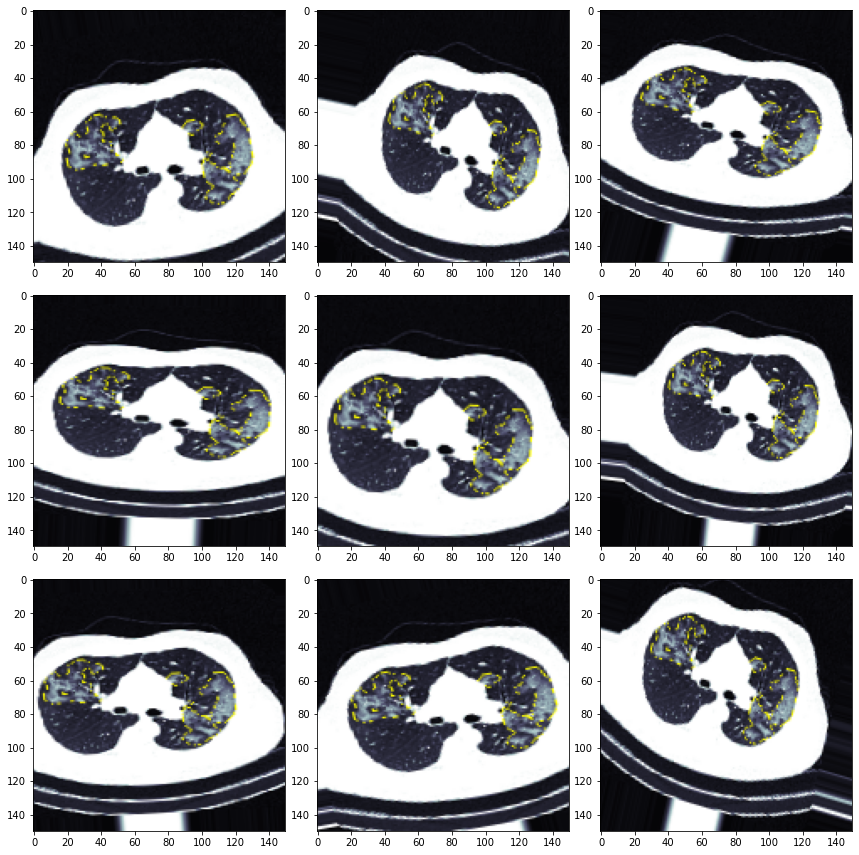

In [15]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = get_data_generator(example_df, "id", "label", class_mode = "categorical")

plt.figure(figsize = (12,12))
for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in example_generator:
            image = X_batch[0]
            plt.imshow(image)
            break
plt.tight_layout()
plt.show()

Building model from scratch

In [16]:
def get_model():
    classifier= Sequential()

    classifier.add(Convolution2D(32, (3, 3), input_shape=(height, width, 3), activation= 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Convolution2D(64, (3, 3), activation= 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Convolution2D(128, (3, 3), activation= 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Convolution2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))
    
    classifier.add(Convolution2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Flatten())

    classifier.add(Dense(units= 512, activation= 'relu'))
    classifier.add(Dense(units= 1, activation= 'sigmoid'))

    classifier.compile(optimizer= 'adam', loss= 'binary_crossentropy' ,metrics= ['accuracy'])

    return classifier

In [17]:
def train_model(model, train_df, validation_df, epochs, callbacks=[]):
    batch_size = 16
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size)
    validation_generator = get_data_generator(validation_df, "id", "label",batch_size=batch_size)

    model.compile(
        optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"]
    )

    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2

    history = model.fit(
        train_generator,
        steps_per_epoch=step_size_train,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=callbacks
    )
    
    #needed when a model is loaded
    np.save('label_legend', train_generator.class_indices)
    
    return history.history

In [18]:
def plot_results(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

Cross Validation

In [19]:
def get_dicts(train_folders_1, train_folders_2, validation_folders_1, validation_folders_2):
    train_set = dict(zip(train_folders_1, ['normal' for i in range(len(train_folders_1))]))
    train_set.update(dict(zip(train_folders_2, ['covid' for i in range(len(train_folders_2))])))
    validation_set = dict(zip(validation_folders_1, ['normal' for i in range(len(validation_folders_1))]))
    validation_set.update(dict(zip(validation_folders_2, ['covid' for i in range(len(validation_folders_2))])))
    return train_set, validation_set

In [20]:
def get_data(train_img_src_folder, train_img_folders, validation_img_src_folder, validation_img_folders):   
    dfs = []
    train_images = {"id": [], "label": []}
    validation_images = {"id": [], "label": []}

    df_config = [
        (train_img_src_folder, train_img_folders, train_images),
        (validation_img_src_folder, validation_img_folders, validation_images)
    ]
    
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = 'segmented'))
            imgs_filename = imgs_filename[(len(imgs_filename)-EXAM_SLICE)//2:(len(imgs_filename)+EXAM_SLICE)//2]
            dic["id"].extend(imgs_filename)
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))

    train_df, validation_df = dfs[0], dfs[1]

    train_df.to_csv('train_df.csv', index=False)
    validation_df.to_csv('validation_df.csv', index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    
    return train_df, validation_df

In [21]:
def plot_all_acc(results):
    for history in results:
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']

        epochs = range(1, len(acc) + 1)
        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and Validation accuracy')
        plt.legend()

        #plt.figure()
        plt.show()

In [22]:
def cross_validation(label_1_patients, label_2_patients, valid_num):
    all_results = []
    for i in range(0, len(label_1_patients), valid_num):
        validation_folders_1 = label_1_patients[i:i+valid_num]
        validation_folders_2 = label_2_patients[i:i+valid_num]
        train_folders_1 = list(set(label_1_patients) - set(validation_folders_1))
        train_folders_2 = list(set(label_2_patients) - set(validation_folders_2))
        
        print('Validating Folders: ', sorted(validation_folders_1), ',', sorted(validation_folders_2))
        print('Training Folders: ', sorted(train_folders_1), ',', sorted(train_folders_2))
        
        train_img_src_folder = img_src_folder
        validation_img_src_folder = img_src_folder
        
        train_set, validation_set = get_dicts(train_folders_1, train_folders_2, validation_folders_1, validation_folders_2)
        
        EXAM_SLICE = 200
        EPOCHS = 10
        width = 150
        height = 150
        
        train_df, validation_df = get_data(train_img_src_folder, train_set, validation_img_src_folder, validation_set)
        
        model = get_model()
        history = train_model(model, train_df, validation_df, EPOCHS)
        all_results.append(history)
    
    return all_results

Fitting Cross Validation and Visualizing Results

In [23]:
sorted(normal_patients)

['p1', 'p2', 'p3', 'p4', 'p5']

In [24]:
sorted(covid_patients)

['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20']

In [25]:
valid_label_size = 1 #number of patients from each label used in validation set
results = cross_validation(sorted(normal_patients), sorted(covid_patients)[0:5], valid_label_size)

Validating Folders:  ['p1'] , ['p11']
Training Folders:  ['p2', 'p3', 'p4', 'p5'] , ['p12', 'p13', 'p14', 'p15']
Train fold with 1600 images
label
covid     800
normal    800
Name: label, dtype: int64

Validation fold with 400 images
label
covid     200
normal    200
Name: label, dtype: int64
------------------------------
Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 70s 701ms/step - loss: 0.4770 - accuracy: 0.7563 - val_loss: 0.4904 - val_accuracy: 0.8475
Epoch 2/10
100/100 [==============================] - 36s 361ms/step - loss: 0.2164 - accuracy: 0.9181 - val_loss: 1.0174 - val_accuracy: 0.5650
Epoch 3/10
100/100 [==============================] - 44s 435ms/step - loss: 0.1005 - accuracy: 0.9656 - val_loss: 0.9590 - val_accuracy: 0.6400
Epoch 4/10
100/100 [==============================] - 42s 417ms/step - loss: 0.0518 - accuracy: 0.9812 - val_loss: 1.57

100/100 [==============================] - 18s 185ms/step - loss: 0.2362 - accuracy: 0.8975 - val_loss: 3.1163 - val_accuracy: 0.5625
Epoch 3/10
100/100 [==============================] - 19s 190ms/step - loss: 0.1110 - accuracy: 0.9600 - val_loss: 3.1471 - val_accuracy: 0.5625
Epoch 4/10
100/100 [==============================] - 18s 185ms/step - loss: 0.0871 - accuracy: 0.9650 - val_loss: 0.0788 - val_accuracy: 0.9600
Epoch 5/10
100/100 [==============================] - 19s 185ms/step - loss: 0.0516 - accuracy: 0.9775 - val_loss: 5.6822 - val_accuracy: 0.4950
Epoch 6/10
100/100 [==============================] - 19s 189ms/step - loss: 0.0286 - accuracy: 0.9887 - val_loss: 1.1730 - val_accuracy: 0.7550
Epoch 7/10
100/100 [==============================] - 19s 188ms/step - loss: 0.0317 - accuracy: 0.9906 - val_loss: 2.7926 - val_accuracy: 0.5975
Epoch 8/10
100/100 [==============================] - 18s 184ms/step - loss: 0.1099 - accuracy: 0.9712 - val_loss: 5.4260 - val_accuracy: 0.5

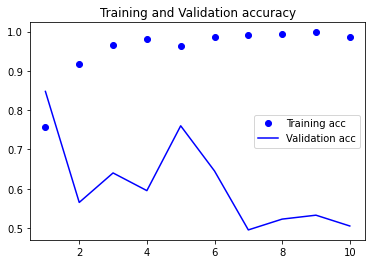

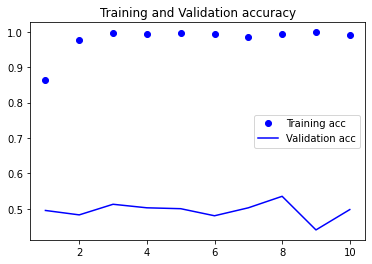

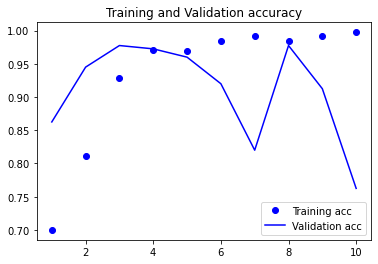

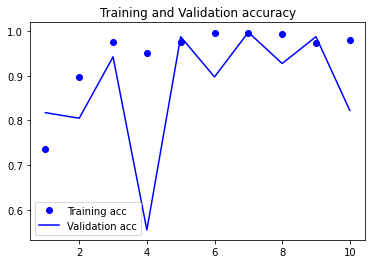

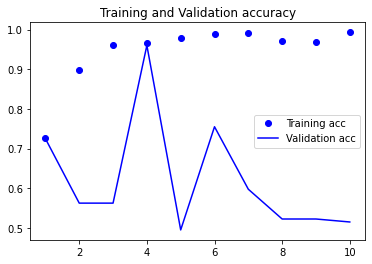

In [26]:
plot_all_acc(results)

Fitting (or Loading) a Final Model

In [27]:
#training a model that performed well in the cross validation to make predictions.
validation_folders_1 = sorted(normal_patients)[2:3] #we'll use p3 and p13 as the validation set
validation_folders_2 = sorted(covid_patients)[2:3] #using and interval so a list is returned
train_folders_1 = list(set(normal_patients) - set(validation_folders_1))
train_folders_2 = list(set(sorted(covid_patients)[0:5]) - set(validation_folders_2))
print("validating: ", validation_folders_1, validation_folders_2)
print("training: ", sorted(train_folders_1), sorted(train_folders_2))
train_set, validation_set = get_dicts(train_folders_1, train_folders_2, validation_folders_1, validation_folders_2)
train_df, validation_df = get_data(img_src_folder, train_set, img_src_folder, validation_set)
model = get_model()
history = train_model(model, train_df, validation_df, EPOCHS)

validating:  ['p3'] ['p13']
training:  ['p1', 'p2', 'p4', 'p5'] ['p11', 'p12', 'p14', 'p15']
Train fold with 1600 images
label
covid     800
normal    800
Name: label, dtype: int64

Validation fold with 400 images
label
covid     200
normal    200
Name: label, dtype: int64
------------------------------
Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 19s 187ms/step - loss: 0.4901 - accuracy: 0.7469 - val_loss: 0.1967 - val_accuracy: 0.9625
Epoch 2/10
100/100 [==============================] - 19s 188ms/step - loss: 0.2026 - accuracy: 0.9262 - val_loss: 0.0489 - val_accuracy: 0.9975
Epoch 3/10
100/100 [==============================] - 19s 192ms/step - loss: 0.0905 - accuracy: 0.9700 - val_loss: 1.4351 - val_accuracy: 0.5925
Epoch 4/10
100/100 [==============================] - 18s 184ms/step - loss: 0.0648 - accuracy: 0.9775 - val_loss: 0.5479 - val_accuracy: 0

In [28]:
#saving the final model
model.save('model.h5')

In [29]:
if os.path.isfile('model.h5'):
    from keras.models import load_model
    model = load_model('model.h5')
    model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 15, 15, 128)      

Making Predictions to Patients in Test Set

In [30]:
test_patients = sorted(TEST_IMG_FOLDERS) 
test_patients

['p16', 'p17', 'p18', 'p19', 'p20']

In [31]:
if len(test_patients)>0:
    batch_size = 16
    width = 150
    height = 150
    results = []
    for p in test_patients:
        curr_dir = img_src_folder + '/' + p + '/segmented/' 
        test_filenames = os.listdir(curr_dir)
        test_df = pd.DataFrame({
                'filename': test_filenames
         })
        nb_samples = test_df.shape[0]

        test_gen = ImageDataGenerator(rescale=1./255)
        test_generator = test_gen.flow_from_dataframe(
                test_df, 
                curr_dir, 
                x_col='filename',
                y_col=None,
                class_mode=None,
                target_size=(width, height),
                batch_size=batch_size,
                shuffle=False
        )

        predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))
        test_df['category'] = [int(round(p[0])) for p in predict]
        results.append(test_df)

Found 431 validated image filenames.
Found 1058 validated image filenames.
Found 468 validated image filenames.
Found 489 validated image filenames.
Found 538 validated image filenames.


Visualizing General Predictions

In [32]:
for i,test_df in enumerate(results):
    print('Patient number: ', i+1)
    if os.path.isfile('label_legend.npy'):
        class_indices = np.load('label_legend.npy', allow_pickle=True).item()
        class_indices = dict((v,k) for k,v in class_indices.items())
        test_df['category'] = test_df['category'].replace(class_indices)
    print(test_df['category'].value_counts())
    print('')

Patient number:  1
covid     312
normal    119
Name: category, dtype: int64

Patient number:  2
covid     877
normal    181
Name: category, dtype: int64

Patient number:  3
normal    319
covid     149
Name: category, dtype: int64

Patient number:  4
covid     394
normal     95
Name: category, dtype: int64

Patient number:  5
covid     330
normal    208
Name: category, dtype: int64

